In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense

In [28]:
#Cargar archivo
df = pd.read_csv('walmart-sales.csv')
print(df.head())

#1 Preprocesamiento de datos

# Convertir la columna 'Date' a datetime y establecerla como índice
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
df = df.groupby(df.index).sum() # Sumamos los valores de los índices duplicados
df = df.sort_index() # Ordenamos los índices

# Se selecciona la serie de tiempo
timeseries = df['Weekly_Sales']

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [29]:
#2 División de datos

# Definir el punto de división
split_date = '2011-09-01'

# Dividir la serie de tiempo en entrenamiento y prueba
train_data, test_data = timeseries[:split_date], timeseries[split_date:]

print("train data", train_data)
print("test data", test_data)

train data Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2011-07-29    43683274.28
2011-08-05    48015466.97
2011-08-12    46249569.21
2011-08-19    46917347.62
2011-08-26    47416948.45
Name: Weekly_Sales, Length: 82, dtype: float64
test data Date
2011-09-02    45376623.27
2011-09-09    46763227.53
2011-09-16    43793960.08
2011-09-23    42718096.73
2011-09-30    42195830.81
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 61, dtype: float64


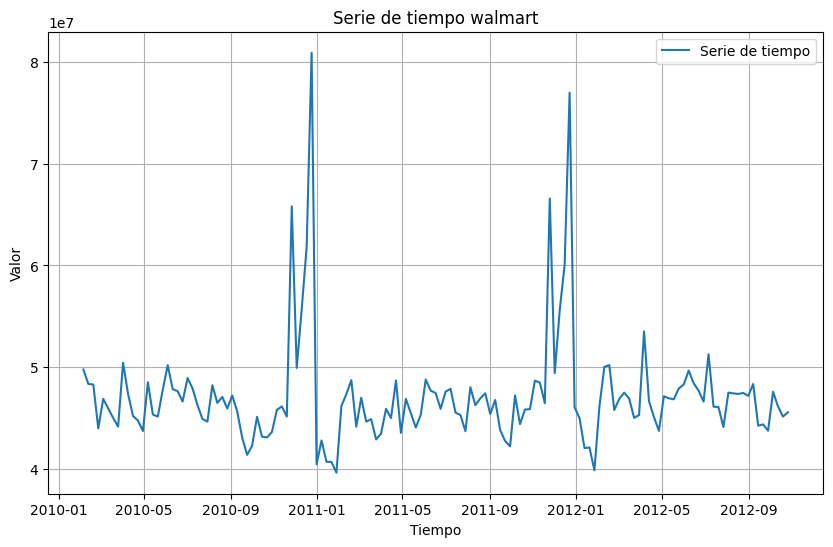

In [30]:
#3. Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(timeseries, label='Serie de tiempo')
plt.title('Serie de tiempo walmart')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# 4. Preparación datos LSTM
# Por ejemplo, transformamos nuestros datos en secuencias
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

#Definimos el número de pasos de tiempo para la serie temporal
seq_length = 16

#Creamos las secuencias de entrenamiento y prueba en formato 3D
X_train, y_train = create_dataset(train_data, seq_length)
X_test, y_test = create_dataset(test_data, seq_length)

<ipython-input-31-d55c21928403>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i+sequence_length])


In [32]:
print(X_train.shape)

(66, 16)


In [33]:
#5. Construcción del modelo LSTM y GRU Y compilación
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(100, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        GRU(50, activation='relu', return_sequences=True),
        Dropout(0.2),
        GRU(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


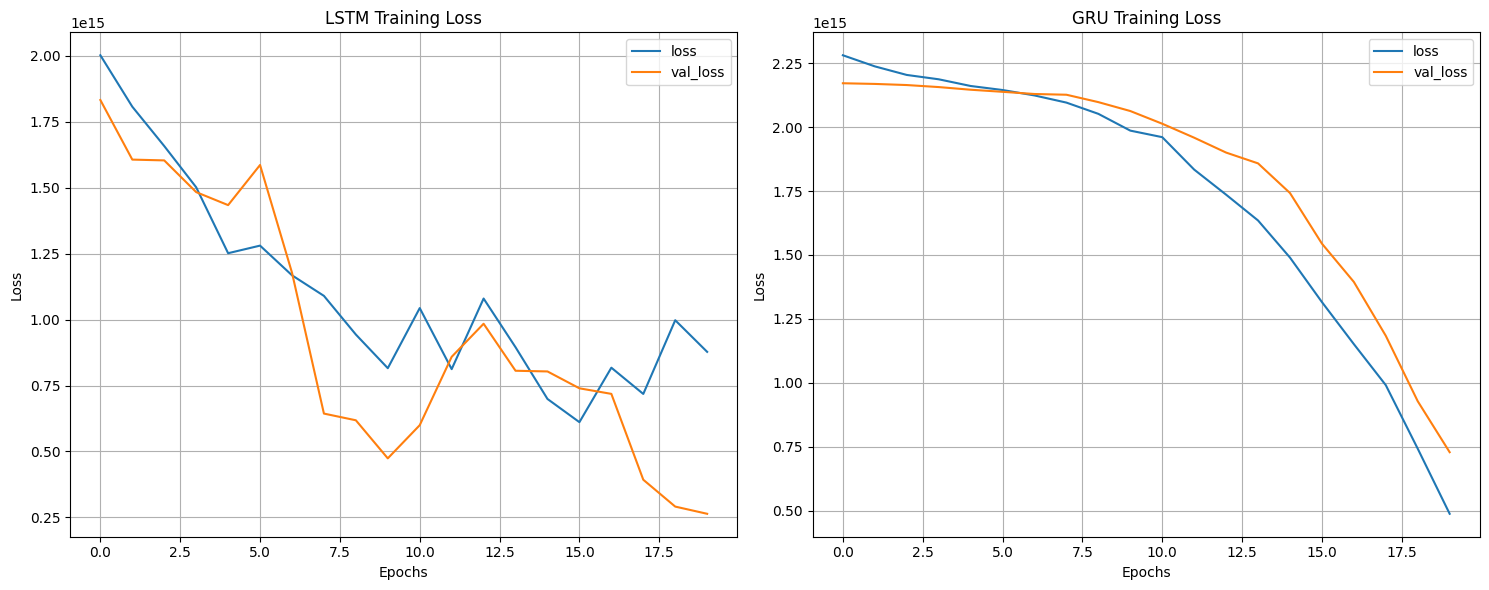

In [34]:
#7. Entrenamiento del modelo

# Reshape para LSTM y GRU (n_samples, timesteps, n_features)
input_shape = (X_train.shape[1],1)

# Crear y entrenar el modelo LSTM
lstm_model = create_lstm_model(input_shape)
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Crear y entrenar el modelo GRU
gru_model = create_gru_model(input_shape)
gru_history = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Crear una figura y dos subgráficas (ejes)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graficar el historial de entrenamiento de LSTM en el primer eje
pd.DataFrame(lstm_history.history).plot(ax=ax1, grid=True)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('LSTM Training Loss')

# Graficar el historial de entrenamiento de GRU en el segundo eje
pd.DataFrame(gru_history.history).plot(ax=ax2, grid=True)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('GRU Training Loss')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

In [35]:
#8. Evaluación del modelo
Evaluacion_lstm =lstm_model.evaluate(X_test, y_test)
Evaluacion_gru =gru_model.evaluate(X_test, y_test)
print("Evaluación modelo lstm:", Evaluacion_lstm)
print("Evaluación modelo gru:", Evaluacion_gru)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 255763540869120.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 749029411520512.0000
Evaluación modelo lstm: 268266761093120.0
Evaluación modelo gru: 744332327911424.0


In [36]:
#9. Predicción
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


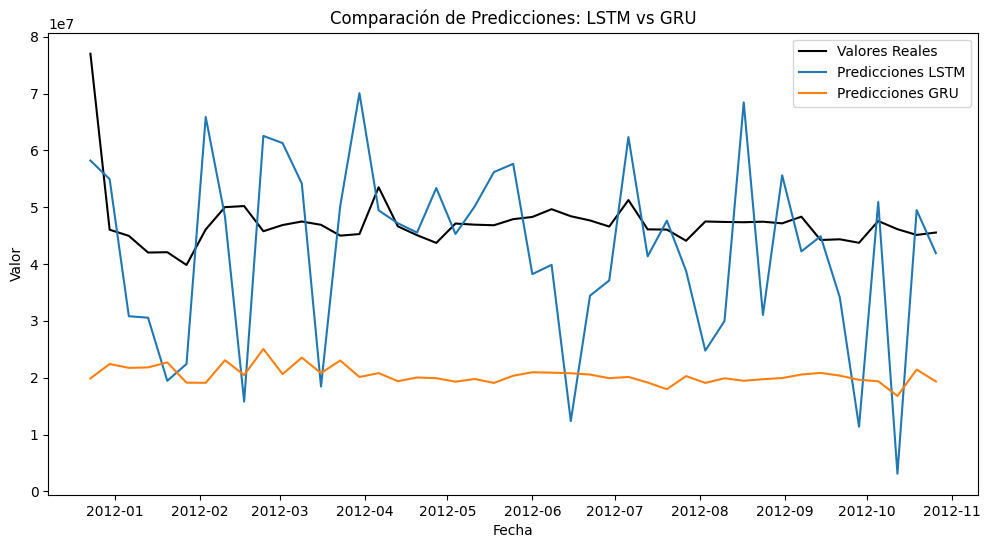

In [37]:
#10.Graficar de la data de test vs pronóstico la serie de tiempo
# Graficar los resultados
plt.figure(figsize=(12, 6))

plt.plot(df.index[-len(y_test):], y_test, label='Valores Reales', color='black')
plt.plot(df.index[-len(y_test):], lstm_predictions, label='Predicciones LSTM')
plt.plot(df.index[-len(y_test):], gru_predictions, label='Predicciones GRU')

plt.legend()
plt.title('Comparación de Predicciones: LSTM vs GRU')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

LSTM Desviación Estándar del Error de Predicción: 15664465.935604753
GRU Desviación Estándar del Error de Predicción: 5361394.548539522


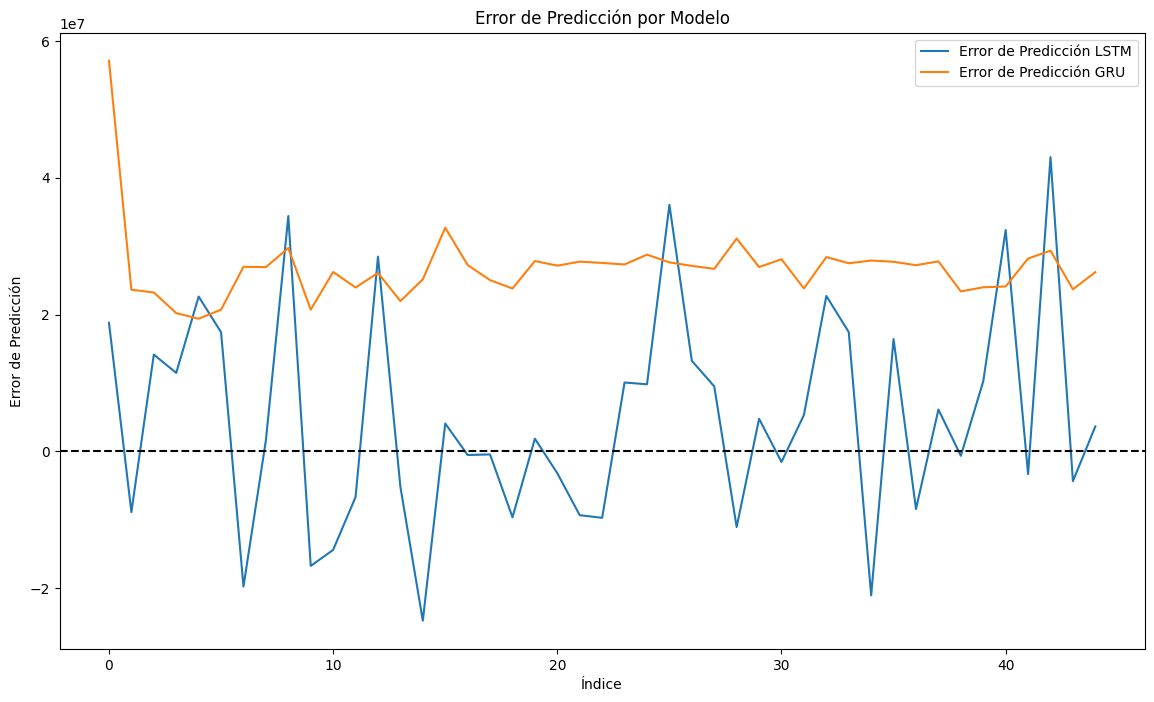

In [38]:
y_test = y_test.flatten()
lstm_predictions = lstm_predictions.flatten()
gru_predictions = gru_predictions.flatten()

# Calcular el error de predicción para cada modelo
prediction_errors = {
    'LSTM': y_test - lstm_predictions,
    'GRU': y_test - gru_predictions
}

# Calcular la desviación estándar para cada modelo
std_devs = {model_name: np.std(errors) for model_name, errors in prediction_errors.items()}

# Mostrar la desviación estándar de los errores de predicción
for model_name, std_dev in std_devs.items():
    print(f"{model_name} Desviación Estándar del Error de Predicción: {std_dev}")

# Generar un rango de índices para la gráfica
indices = np.arange(len(y_test))

# Graficar el error de predicción en cada fecha para cada modelo
plt.figure(figsize=(14, 8))

# Graficar los errores como líneas
for model_name, errors in prediction_errors.items():
    plt.plot(indices, errors, label=f'Error de Predicción {model_name}')

plt.axhline(y=0, color='black', linestyle='--')  # Línea horizontal en y=0 para referencia
plt.title('Error de Predicción por Modelo')
plt.xlabel('Índice')
plt.ylabel('Error de Predicción')
plt.legend()
plt.show()



In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calcular el MSE para LSTM
lstm_mse = mean_squared_error(y_test, lstm_predictions)
print(f"MSE para LSTM: {lstm_mse}")
# Calcular el MSE para GRU
gru_mse = mean_squared_error(y_test, gru_predictions)
print(f"MSE para GRU: {gru_mse}")
print("-----------------------------------------")
# Calcular el MAE para LSTM
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
print(f"MAE para LSTM: {lstm_mae}")
# Calcular el MAE para GRU
gru_mae = mean_absolute_error(y_test, gru_predictions)
print(f"MAE para GRU: {gru_mae}")

MSE para LSTM: 268266785658921.97
MSE para GRU: 744332308126859.9
-----------------------------------------
MAE para LSTM: 12786697.807111107
MAE para GRU: 26750472.08222222


In [40]:
# Determinar el mejor modelo basado en MSE
if lstm_mse < gru_mse:
    best_mse_model = 'LSTM'
    best_mse_value = lstm_mse
else:
    best_mse_model = 'GRU'
    best_mse_value = gru_mse

# Determinar el mejor modelo basado en MAE
if lstm_mae < gru_mae:
    best_mae_model = 'LSTM'
    best_mae_value = lstm_mae
else:
    best_mae_model = 'GRU'
    best_mae_value = gru_mae

# Mostrar el mejor modelo para MSE
print(f"El mejor modelo basado en MSE es: {best_mse_model} con un MSE de {best_mse_value}")

# Mostrar el mejor modelo para MAE
print(f"El mejor modelo basado en MAE es: {best_mae_model} con un MAE de {best_mae_value}")

# Determinar el modelo final basado en ambas métricas (opcional)
if best_mse_model == best_mae_model:
    print(f"El modelo final que es mejor en ambas métricas es: {best_mse_model}")
else:
    print(f"El mejor modelo según MSE es: {best_mse_model}")
    print(f"El mejor modelo según MAE es: {best_mae_model}")

El mejor modelo basado en MSE es: LSTM con un MSE de 268266785658921.97
El mejor modelo basado en MAE es: LSTM con un MAE de 12786697.807111107
El modelo final que es mejor en ambas métricas es: LSTM
